In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import  plot_model ,Sequence
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp
from PIL import Image
import os
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

In [3]:
%cd /content/drive/MyDrive/Explo_2024_sem4

/content/drive/MyDrive/Explo_2024_sem4


In [ ]:
path = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/annotations'

for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_train/{}'.format(f))

In [ ]:
path = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/val/annotations'

for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_valid/{}'.format(f))

In [ ]:
train_img_dir = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/images/'
train_mask_dir = '/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_train/'
train_imgs = os.listdir(train_img_dir)# if you have an error take a look here ...
train_masks = os.listdir(train_mask_dir)
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])
print(len(train_imgs))
print(len(train_masks))

1341
1341


In [ ]:
print(train_imgs[:])
print(train_masks[:])

['seq_10_frame000.png', 'seq_10_frame001.png', 'seq_10_frame002.png', 'seq_10_frame003.png', 'seq_10_frame004.png', 'seq_10_frame005.png', 'seq_10_frame006.png', 'seq_10_frame007.png', 'seq_10_frame008.png', 'seq_10_frame009.png', 'seq_10_frame010.png', 'seq_10_frame011.png', 'seq_10_frame012.png', 'seq_10_frame013.png', 'seq_10_frame014.png', 'seq_10_frame015.png', 'seq_10_frame016.png', 'seq_10_frame017.png', 'seq_10_frame018.png', 'seq_10_frame019.png', 'seq_10_frame020.png', 'seq_10_frame021.png', 'seq_10_frame022.png', 'seq_10_frame023.png', 'seq_10_frame024.png', 'seq_10_frame025.png', 'seq_10_frame026.png', 'seq_10_frame027.png', 'seq_10_frame028.png', 'seq_10_frame029.png', 'seq_10_frame030.png', 'seq_10_frame031.png', 'seq_10_frame032.png', 'seq_10_frame033.png', 'seq_10_frame034.png', 'seq_10_frame035.png', 'seq_10_frame036.png', 'seq_10_frame037.png', 'seq_10_frame038.png', 'seq_10_frame039.png', 'seq_10_frame040.png', 'seq_10_frame041.png', 'seq_10_frame042.png', 'seq_10_fr

In [ ]:
from sklearn.model_selection import train_test_split

val_img_dir =  train_img_dir
val_mask_dir = train_mask_dir


train_imgs,val_imgs,train_masks,val_masks =  train_test_split(train_imgs, train_masks, test_size=0.13, random_state=42)


print(len(train_masks))
print(len(val_masks))

1166
175


In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
#             degree=np.random.random() * 360
            # Store sample
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
#             img = ndimage.rotate(img, degree)
#             print(img)
            batch_imgs.append(img)
           # Store class
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

In [ ]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

32

<ipython-input-23-ed9b101b261f>:57: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-23-ed9b101b261f>:58: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


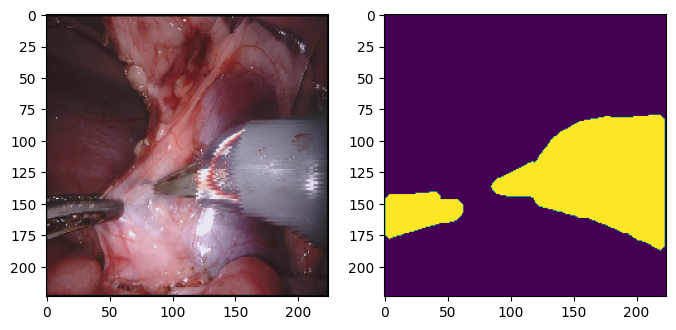

In [ ]:
X,y = train_generator.__getitem__(2)
t = 12

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

In [ ]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

4

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(224 , 224 , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[0][0]

In [ ]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
model.compile(optimizer='adam', loss=jaccard_distance_loss ,metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = []
model.metrics_names

[]

In [ ]:

results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

<ipython-input-33-d70f7477409c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)
<ipython-input-23-ed9b101b261f>:57: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-23-ed9b101b261f>:58: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/40
32/32 [==============================] - 178s 3s/step - loss: 0.1810 - dice_coef: 0.5745 - accuracy: 0.8653 - val_loss: 0.8406 - val_dice_coef: 0.2594 - val_accuracy: 0.1508
Epoch 2/40
32/32 [==============================] - 99s 3s/step - loss: 0.0928 - dice_coef: 0.7326 - accuracy: 0.9281 - val_loss: 0.6357 - val_dice_coef: 0.2484 - val_accuracy: 0.3659
Epoch 3/40
32/32 [==============================] - 99s 3s/step - loss: 0.0686 - dice_coef: 0.7980 - accuracy: 0.9441 - val_loss: 0.5494 - val_dice_coef: 0.2903 - val_accuracy: 0.4550
Epoch 4/40
32/32 [==============================] - 97s 3s/step - loss: 0.0539 - dice_coef: 0.8394 - accuracy: 0.9549 - val_loss: 0.5022 - val_dice_coef: 0.2706 - val_accuracy: 0.5001
Epoch 5/40
32/32 [==============================] - 98s 3s/step - loss: 0.0502 - dice_coef: 0.8497 - accuracy: 0.9560 - val_loss: 0.1958 - val_dice_coef: 0.3813 - val_accuracy: 0.8141
Epoch 6/40
32/32 [==============================] - 100s 3s/step - loss: 0.0435

In [ ]:
model.save('/content/drive/MyDrive/Explo_2024_sem4/U_NET_Pretrained', save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("model.keras")

In [ ]:
loss = results.history["loss"]
# val_loss = results.history["val_loss"]

dice_coef = results.history["dice_coef"]
# val_dice_coef = results.history["val_dice_coef"]

acc = results.history["accuracy"]
# val_acc = results.history["val_accuracy"]

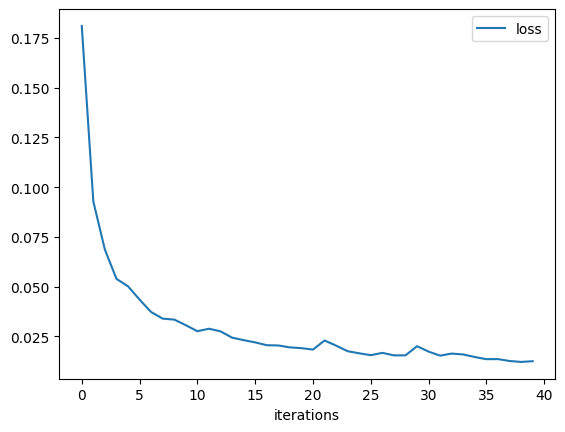

In [ ]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

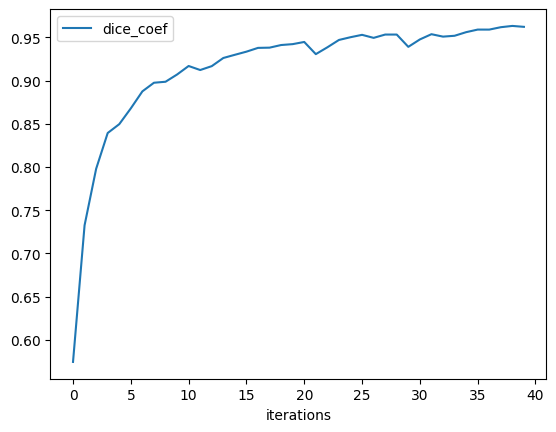

In [ ]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

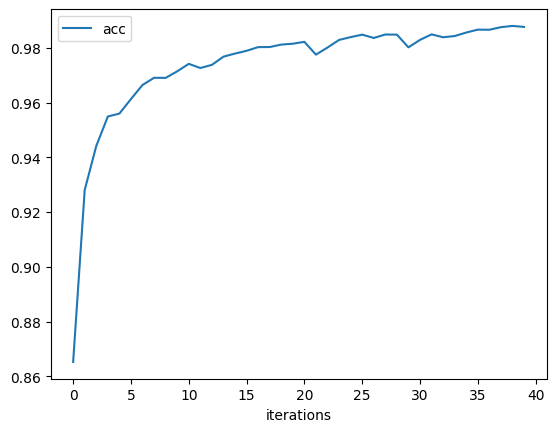

In [ ]:
plt.plot(acc,label = "acc")
# plt.plot(val_acc,label  = "val acc")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

In [ ]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = (mask[0] > 0.5)*1
#     print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask

(1024, 1280, 3)

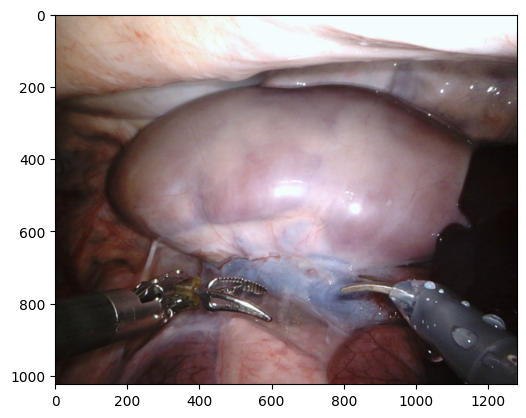

In [ ]:
image = "/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/images/seq_10_frame000.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 4s 4s/step
(1024, 1280, 3) (224, 224, 3)


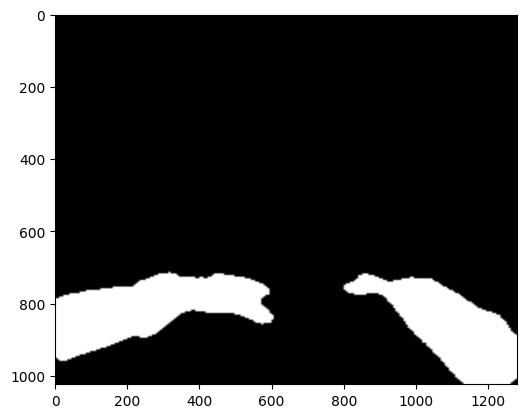

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

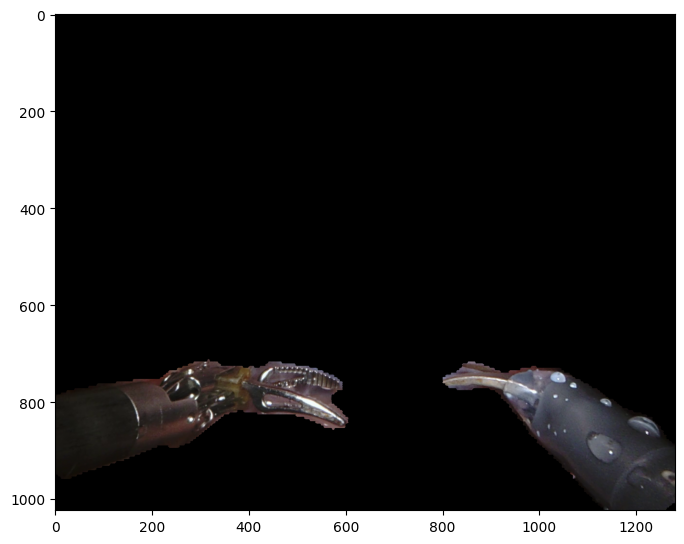

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

(1024, 1280, 3)

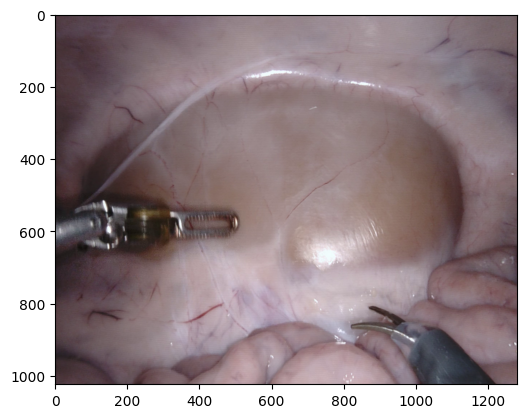

In [ ]:
image = "/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/val/images/seq_15_frame000.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 0s 40ms/step
(1024, 1280, 3) (224, 224, 3)


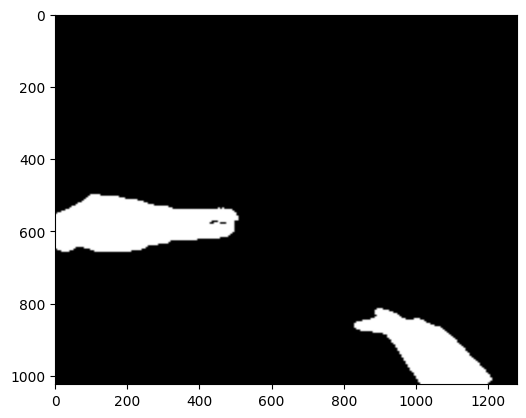

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

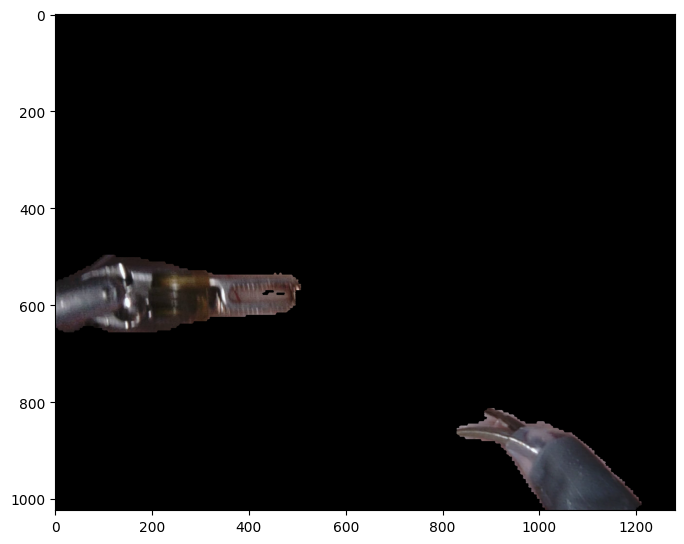

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

In [4]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

Writing app.py


In [11]:
! wget -q -O - ipv4.icanhazip.com

34.16.136.117


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.136.117:8501

npx: installed 22 in 3.046s
your url is: https://tame-bars-roll.loca.lt
2024-04-14 20:00:23.712075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 20:00:23.712158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 20:00:23.717276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 20:00:25.640839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-14 20:00:36.880 `lab

In [8]:
from skimage.io import imread
from skimage.transform import resize

# function to predict result
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

import tensorflow as tf

def iou_score(y_true, y_pred):
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()
    return iou
def f1_score(y_true, y_pred):
  # Compute the F1 score using sklearn's f1_score function
  # You may need to adjust the parameters depending on your task
  return f1_score(y_true, y_pred)
# Define custom objects dictionary
custom_objects = {'BatchNormalization': tf.keras.layers.BatchNormalization}
# Register the custom metric function
tf.keras.utils.get_custom_objects()['iou_score'] = iou_score
tf.keras.utils.get_custom_objects()['f1-score'] = f1_score
# Load the model with custom objects
VGG16 = tf.keras.models.load_model('/content/drive/MyDrive/Explo_2024_sem4/VGG16.h5', custom_objects=custom_objects)

1/1 [==============================] - 4s 4s/step


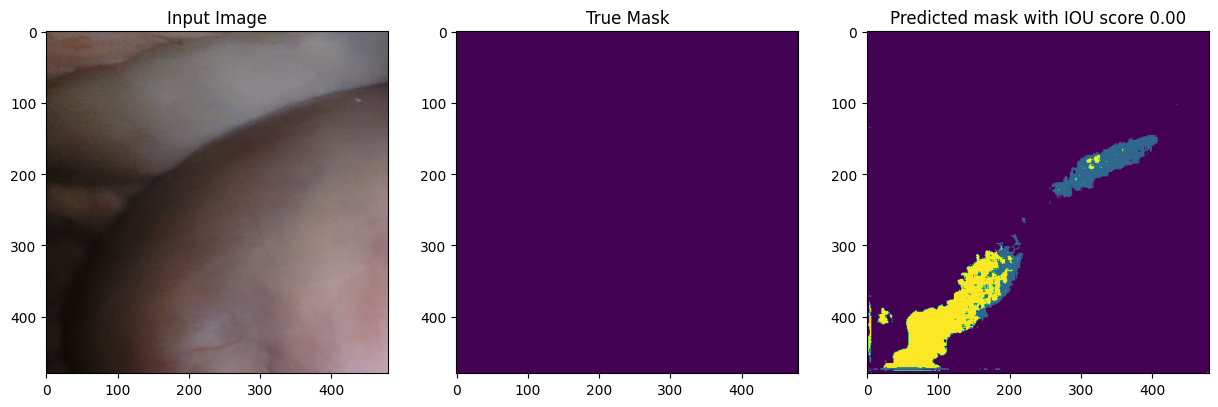

In [10]:
img_path = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/images/seq_10_frame004.png'
mask_path = '/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_train/seq_10_frame004.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, VGG16)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()